In [1]:
from sklearn.linear_model import SGDClassifier  # Replaces KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import os
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_score, recall_score, f1_score
from copy import deepcopy
from math import sqrt
from sklearn.utils import resample
from sklearn.metrics import make_scorer, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

In [2]:
merged_cohort = pd.read_csv("merged_file.csv")
y = merged_cohort['Outcome_Occlusion_MI']
X = merged_cohort.drop('Outcome_Occlusion_MI', axis=1)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2,  # 30% for val+test (which is 15%+15%)
    stratify=y,
    random_state=99
)
'''
# Step 2: Split the temp set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,  # 50% of 30% = 15% of original data
    stratify=y_temp,  # Maintain stratification in this split too
    random_state=99
)
'''
# Verify the proportions
print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X):.1%})")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X):.1%})")
#print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X):.1%})")

Training set: 5850 samples (80.0%)
Validation set: 1463 samples (20.0%)


In [3]:
for el in X_train.columns:
    X_train[el].fillna(X_train[el].mode()[0], inplace=True)
    #X_test[el].fillna(X_train[el].mode()[0], inplace=True)
    X_val[el].fillna(X_train[el].mode()[0], inplace=True)

y_train = np.ravel(np.array(y_train.values))
#y_test = np.ravel(np.array(y_test.values))
y_val = np.ravel(np.array(y_val.values))

columns = X_train.columns

X_train = np.array(X_train.values)
#X_test = np.array(X_test.values)
X_val = np.array(X_val.values)

scaler = preprocessing.StandardScaler().fit(X_train) # Compute mean and std of training set
X_train = scaler.transform(X_train, copy=True)
#X_test = scaler.transform(X_test, copy=True) # Standardize X_test using training mean and std
X_val = scaler.transform(X_val, copy=True)

C:\Users\arthu\AppData\Local\Temp\ipykernel_103396\2349841912.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[el].fillna(X_train[el].mode()[0], inplace=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_103396\2349841912.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

In [4]:
def plot_ROC_curve(fpr, tpr, roc_auc, title):
    plt.figure(figsize=[5, 5])
    plt.title(title)
    plt.plot(fpr, tpr, color='b',
                 label=r'SGD_log_reg (AUC = %0.3f)' % (roc_auc),
                 lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey', alpha=.5)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate = 1 - Specificity')
    plt.ylabel('True Positive Rate = Sensitivity')
    plt.legend(loc="lower right")
    plt.show()

In [5]:
def results(pred_probas):
    OMI_score = np.round(pred_probas[:, 1]*100, decimals=2)
    y_pred = np.where(OMI_score<5, 'Low risk', 'Intermediate risk')
    y_pred = np.where(OMI_score>=20, 'High risk', y_pred)
    
    results = {
        'Low risk': [np.count_nonzero(y_pred == 'Low risk')],
        'Intermediate risk': [np.count_nonzero(y_pred == 'Intermediate risk')],
        'High risk': [np.count_nonzero(y_pred == 'High risk')]
    }
    return(pd.DataFrame(data=results, index=['Count (N)']))

In [6]:
def bootstrap_metric_ci(y_true, y_pred, metric_fn, n_bootstrap=1000, alpha=0.05):
    """
    Compute 95% confidence interval using bootstrapping for any metric.
    
    Parameters:
    - y_true: Ground truth labels (0 or 1).
    - y_pred: Predicted values (either probabilities or binary predictions).
    - metric_fn: Metric function (roc_auc_score, recall_score, f1_score).
    - n_bootstrap: Number of bootstrap resamples.
    - alpha: Significance level (default 0.05 for 95% CI).

    Returns:
    - Lower and upper bound of the confidence interval.
    """
    scores = []
    
    for _ in range(n_bootstrap):
        # Resample dataset with replacement
        indices = resample(range(len(y_true)), replace=True, n_samples=len(y_true))
        y_true_bootstrap = np.array(y_true)[indices]
        y_pred_bootstrap = np.array(y_pred)[indices]

        # Special case for AUROC: Use roc_curve and auc()
        if metric_fn == "auroc":
            fpr, tpr, _ = roc_curve(y_true_bootstrap, y_pred_bootstrap)
            score = auc(fpr, tpr)
        else:
            score = metric_fn(y_true_bootstrap, y_pred_bootstrap)

        scores.append(score)
    
    # Compute confidence interval
    lower_bound = np.percentile(scores, 100 * (alpha / 2))
    upper_bound = np.percentile(scores, 100 * (1 - alpha / 2))
    
    return lower_bound, upper_bound

Hyperparameter Tuning with 10-Fold Cross-Validation
Searching for optimal hyperparameters across 144 combinations...


  1%|█▍                                                                                                                                                                                                               | 1/144 [00:00<00:59,  2.40it/s]

Parameters: alpha=0.0001, penalty=l2, learning_rate=optimal, eta0=N/A, CV AUROC=0.8341 ± 0.0244


  3%|███████▎                                                                                                                                                                                                         | 5/144 [00:00<00:19,  7.05it/s]

Parameters: alpha=0.0001, penalty=l2, learning_rate=invscaling, eta0=0.01, CV AUROC=0.8327 ± 0.0410
Parameters: alpha=0.0001, penalty=l2, learning_rate=invscaling, eta0=0.1, CV AUROC=0.8632 ± 0.0349
Parameters: alpha=0.0001, penalty=l2, learning_rate=invscaling, eta0=1, CV AUROC=0.8646 ± 0.0337


  6%|█████████████                                                                                                                                                                                                    | 9/144 [00:01<00:13,  9.78it/s]

Parameters: alpha=0.0001, penalty=l2, learning_rate=constant, eta0=0.01, CV AUROC=0.8590 ± 0.0263
Parameters: alpha=0.0001, penalty=l2, learning_rate=constant, eta0=0.1, CV AUROC=0.7590 ± 0.0291
Parameters: alpha=0.0001, penalty=l2, learning_rate=constant, eta0=1, CV AUROC=0.7180 ± 0.0597
Parameters: alpha=0.0001, penalty=l2, learning_rate=adaptive, eta0=0.01, CV AUROC=0.8646 ± 0.0354


  8%|███████████████▉                                                                                                                                                                                                | 11/144 [00:01<00:25,  5.18it/s]

Parameters: alpha=0.0001, penalty=l2, learning_rate=adaptive, eta0=0.1, CV AUROC=0.8600 ± 0.0362


  8%|█████████████████▎                                                                                                                                                                                              | 12/144 [00:02<00:33,  3.89it/s]

Parameters: alpha=0.0001, penalty=l2, learning_rate=adaptive, eta0=1, CV AUROC=0.8601 ± 0.0352


  9%|██████████████████▊                                                                                                                                                                                             | 13/144 [00:03<00:52,  2.49it/s]

Parameters: alpha=0.0001, penalty=l1, learning_rate=optimal, eta0=N/A, CV AUROC=0.8265 ± 0.0371


 12%|████████████████████████▌                                                                                                                                                                                       | 17/144 [00:03<00:32,  3.90it/s]

Parameters: alpha=0.0001, penalty=l1, learning_rate=invscaling, eta0=0.01, CV AUROC=0.8320 ± 0.0412
Parameters: alpha=0.0001, penalty=l1, learning_rate=invscaling, eta0=0.1, CV AUROC=0.8630 ± 0.0349


 12%|██████████████████████████                                                                                                                                                                                      | 18/144 [00:04<00:30,  4.14it/s]

Parameters: alpha=0.0001, penalty=l1, learning_rate=invscaling, eta0=1, CV AUROC=0.8650 ± 0.0340
Parameters: alpha=0.0001, penalty=l1, learning_rate=constant, eta0=0.01, CV AUROC=0.8632 ± 0.0283


 14%|████████████████████████████▉                                                                                                                                                                                   | 20/144 [00:04<00:32,  3.77it/s]

Parameters: alpha=0.0001, penalty=l1, learning_rate=constant, eta0=0.1, CV AUROC=0.7784 ± 0.0481


 15%|██████████████████████████████▎                                                                                                                                                                                 | 21/144 [00:05<00:36,  3.37it/s]

Parameters: alpha=0.0001, penalty=l1, learning_rate=constant, eta0=1, CV AUROC=0.7422 ± 0.0535


 15%|███████████████████████████████▊                                                                                                                                                                                | 22/144 [00:05<00:43,  2.81it/s]

Parameters: alpha=0.0001, penalty=l1, learning_rate=adaptive, eta0=0.01, CV AUROC=0.8657 ± 0.0350


 16%|█████████████████████████████████▏                                                                                                                                                                              | 23/144 [00:06<01:07,  1.78it/s]

Parameters: alpha=0.0001, penalty=l1, learning_rate=adaptive, eta0=0.1, CV AUROC=0.8614 ± 0.0356


 17%|██████████████████████████████████▋                                                                                                                                                                             | 24/144 [00:08<01:39,  1.21it/s]

Parameters: alpha=0.0001, penalty=l1, learning_rate=adaptive, eta0=1, CV AUROC=0.8579 ± 0.0392


 17%|████████████████████████████████████                                                                                                                                                                            | 25/144 [00:08<01:38,  1.20it/s]

Parameters: alpha=0.0001, penalty=elasticnet, learning_rate=optimal, eta0=N/A, CV AUROC=0.8214 ± 0.0449


 20%|█████████████████████████████████████████▉                                                                                                                                                                      | 29/144 [00:09<00:45,  2.51it/s]

Parameters: alpha=0.0001, penalty=elasticnet, learning_rate=invscaling, eta0=0.01, CV AUROC=0.8326 ± 0.0410
Parameters: alpha=0.0001, penalty=elasticnet, learning_rate=invscaling, eta0=0.1, CV AUROC=0.8632 ± 0.0349


 22%|████████████████████████████████████████████▊                                                                                                                                                                   | 31/144 [00:09<00:33,  3.34it/s]

Parameters: alpha=0.0001, penalty=elasticnet, learning_rate=invscaling, eta0=1, CV AUROC=0.8647 ± 0.0337
Parameters: alpha=0.0001, penalty=elasticnet, learning_rate=constant, eta0=0.01, CV AUROC=0.8620 ± 0.0273


 22%|██████████████████████████████████████████████▏                                                                                                                                                                 | 32/144 [00:10<00:30,  3.71it/s]

Parameters: alpha=0.0001, penalty=elasticnet, learning_rate=constant, eta0=0.1, CV AUROC=0.7789 ± 0.0293


 23%|███████████████████████████████████████████████▋                                                                                                                                                                | 33/144 [00:10<00:29,  3.72it/s]

Parameters: alpha=0.0001, penalty=elasticnet, learning_rate=constant, eta0=1, CV AUROC=0.7343 ± 0.0631


 24%|█████████████████████████████████████████████████                                                                                                                                                               | 34/144 [00:10<00:35,  3.07it/s]

Parameters: alpha=0.0001, penalty=elasticnet, learning_rate=adaptive, eta0=0.01, CV AUROC=0.8647 ± 0.0353


 24%|██████████████████████████████████████████████████▌                                                                                                                                                             | 35/144 [00:11<00:50,  2.17it/s]

Parameters: alpha=0.0001, penalty=elasticnet, learning_rate=adaptive, eta0=0.1, CV AUROC=0.8607 ± 0.0357


 26%|█████████████████████████████████████████████████████▍                                                                                                                                                          | 37/144 [00:13<00:57,  1.86it/s]

Parameters: alpha=0.0001, penalty=elasticnet, learning_rate=adaptive, eta0=1, CV AUROC=0.8613 ± 0.0352
Parameters: alpha=0.001, penalty=l2, learning_rate=optimal, eta0=N/A, CV AUROC=0.8557 ± 0.0377


 28%|███████████████████████████████████████████████████████████▏                                                                                                                                                    | 41/144 [00:13<00:26,  3.96it/s]

Parameters: alpha=0.001, penalty=l2, learning_rate=invscaling, eta0=0.01, CV AUROC=0.8326 ± 0.0410
Parameters: alpha=0.001, penalty=l2, learning_rate=invscaling, eta0=0.1, CV AUROC=0.8628 ± 0.0351


 30%|██████████████████████████████████████████████████████████████                                                                                                                                                  | 43/144 [00:13<00:19,  5.15it/s]

Parameters: alpha=0.001, penalty=l2, learning_rate=invscaling, eta0=1, CV AUROC=0.8661 ± 0.0346
Parameters: alpha=0.001, penalty=l2, learning_rate=constant, eta0=0.01, CV AUROC=0.8547 ± 0.0319
Parameters: alpha=0.001, penalty=l2, learning_rate=constant, eta0=0.1, CV AUROC=0.7420 ± 0.0497


 31%|█████████████████████████████████████████████████████████████████                                                                                                                                               | 45/144 [00:13<00:15,  6.59it/s]

Parameters: alpha=0.001, penalty=l2, learning_rate=constant, eta0=1, CV AUROC=0.6849 ± 0.0596


 32%|██████████████████████████████████████████████████████████████████▍                                                                                                                                             | 46/144 [00:14<00:18,  5.40it/s]

Parameters: alpha=0.001, penalty=l2, learning_rate=adaptive, eta0=0.01, CV AUROC=0.8664 ± 0.0357


 33%|███████████████████████████████████████████████████████████████████▉                                                                                                                                            | 47/144 [00:14<00:22,  4.33it/s]

Parameters: alpha=0.001, penalty=l2, learning_rate=adaptive, eta0=0.1, CV AUROC=0.8653 ± 0.0355


 33%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                          | 48/144 [00:14<00:27,  3.54it/s]

Parameters: alpha=0.001, penalty=l2, learning_rate=adaptive, eta0=1, CV AUROC=0.8655 ± 0.0348


 34%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 49/144 [00:17<01:31,  1.04it/s]

Parameters: alpha=0.001, penalty=l1, learning_rate=optimal, eta0=N/A, CV AUROC=0.8266 ± 0.0308


 36%|███████████████████████████████████████████████████████████████████████████                                                                                                                                     | 52/144 [00:18<00:50,  1.82it/s]

Parameters: alpha=0.001, penalty=l1, learning_rate=invscaling, eta0=0.01, CV AUROC=0.8270 ± 0.0422
Parameters: alpha=0.001, penalty=l1, learning_rate=invscaling, eta0=0.1, CV AUROC=0.8589 ± 0.0349


 38%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                  | 54/144 [00:18<00:37,  2.39it/s]

Parameters: alpha=0.001, penalty=l1, learning_rate=invscaling, eta0=1, CV AUROC=0.8677 ± 0.0345
Parameters: alpha=0.001, penalty=l1, learning_rate=constant, eta0=0.01, CV AUROC=0.8636 ± 0.0337


 39%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 56/144 [00:19<00:30,  2.90it/s]

Parameters: alpha=0.001, penalty=l1, learning_rate=constant, eta0=0.1, CV AUROC=0.8089 ± 0.0485


 40%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 57/144 [00:19<00:31,  2.78it/s]

Parameters: alpha=0.001, penalty=l1, learning_rate=constant, eta0=1, CV AUROC=0.7490 ± 0.0425


 40%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 58/144 [00:20<00:36,  2.39it/s]

Parameters: alpha=0.001, penalty=l1, learning_rate=adaptive, eta0=0.01, CV AUROC=0.8672 ± 0.0359


 41%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 59/144 [00:21<00:46,  1.81it/s]

Parameters: alpha=0.001, penalty=l1, learning_rate=adaptive, eta0=0.1, CV AUROC=0.8672 ± 0.0357


 42%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 60/144 [00:22<01:05,  1.28it/s]

Parameters: alpha=0.001, penalty=l1, learning_rate=adaptive, eta0=1, CV AUROC=0.8659 ± 0.0378


 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 61/144 [00:22<00:55,  1.51it/s]

Parameters: alpha=0.001, penalty=elasticnet, learning_rate=optimal, eta0=N/A, CV AUROC=0.8634 ± 0.0336


 44%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 64/144 [00:23<00:30,  2.63it/s]

Parameters: alpha=0.001, penalty=elasticnet, learning_rate=invscaling, eta0=0.01, CV AUROC=0.8317 ± 0.0412
Parameters: alpha=0.001, penalty=elasticnet, learning_rate=invscaling, eta0=0.1, CV AUROC=0.8627 ± 0.0351


 46%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 66/144 [00:23<00:23,  3.32it/s]

Parameters: alpha=0.001, penalty=elasticnet, learning_rate=invscaling, eta0=1, CV AUROC=0.8667 ± 0.0351
Parameters: alpha=0.001, penalty=elasticnet, learning_rate=constant, eta0=0.01, CV AUROC=0.8612 ± 0.0347


 47%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 68/144 [00:24<00:22,  3.45it/s]

Parameters: alpha=0.001, penalty=elasticnet, learning_rate=constant, eta0=0.1, CV AUROC=0.7905 ± 0.0498


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 69/144 [00:24<00:25,  2.98it/s]

Parameters: alpha=0.001, penalty=elasticnet, learning_rate=constant, eta0=1, CV AUROC=0.7304 ± 0.0471


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 70/144 [00:25<00:29,  2.51it/s]

Parameters: alpha=0.001, penalty=elasticnet, learning_rate=adaptive, eta0=0.01, CV AUROC=0.8678 ± 0.0358


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 71/144 [00:26<00:40,  1.81it/s]

Parameters: alpha=0.001, penalty=elasticnet, learning_rate=adaptive, eta0=0.1, CV AUROC=0.8664 ± 0.0362


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 72/144 [00:27<00:55,  1.31it/s]

Parameters: alpha=0.001, penalty=elasticnet, learning_rate=adaptive, eta0=1, CV AUROC=0.8651 ± 0.0384


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 73/144 [00:27<00:45,  1.54it/s]

Parameters: alpha=0.01, penalty=l2, learning_rate=optimal, eta0=N/A, CV AUROC=0.8545 ± 0.0464


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 77/144 [00:28<00:19,  3.47it/s]

Parameters: alpha=0.01, penalty=l2, learning_rate=invscaling, eta0=0.01, CV AUROC=0.8308 ± 0.0414
Parameters: alpha=0.01, penalty=l2, learning_rate=invscaling, eta0=0.1, CV AUROC=0.8584 ± 0.0358
Parameters: alpha=0.01, penalty=l2, learning_rate=invscaling, eta0=1, CV AUROC=0.8582 ± 0.0314


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 81/144 [00:28<00:10,  6.06it/s]

Parameters: alpha=0.01, penalty=l2, learning_rate=constant, eta0=0.01, CV AUROC=0.8471 ± 0.0329
Parameters: alpha=0.01, penalty=l2, learning_rate=constant, eta0=0.1, CV AUROC=0.7147 ± 0.0755
Parameters: alpha=0.01, penalty=l2, learning_rate=constant, eta0=1, CV AUROC=0.5901 ± 0.1024


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 82/144 [00:28<00:11,  5.52it/s]

Parameters: alpha=0.01, penalty=l2, learning_rate=adaptive, eta0=0.01, CV AUROC=0.8645 ± 0.0376


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 83/144 [00:29<00:13,  4.59it/s]

Parameters: alpha=0.01, penalty=l2, learning_rate=adaptive, eta0=0.1, CV AUROC=0.8638 ± 0.0378


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 84/144 [00:29<00:15,  3.87it/s]

Parameters: alpha=0.01, penalty=l2, learning_rate=adaptive, eta0=1, CV AUROC=0.8641 ± 0.0379


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 85/144 [00:31<00:39,  1.51it/s]

Parameters: alpha=0.01, penalty=l1, learning_rate=optimal, eta0=N/A, CV AUROC=0.8047 ± 0.0259


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 88/144 [00:32<00:25,  2.22it/s]

Parameters: alpha=0.01, penalty=l1, learning_rate=invscaling, eta0=0.01, CV AUROC=0.7836 ± 0.0392


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 89/144 [00:32<00:22,  2.42it/s]

Parameters: alpha=0.01, penalty=l1, learning_rate=invscaling, eta0=0.1, CV AUROC=0.8090 ± 0.0357
Parameters: alpha=0.01, penalty=l1, learning_rate=invscaling, eta0=1, CV AUROC=0.8179 ± 0.0332


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 91/144 [00:32<00:17,  3.05it/s]

Parameters: alpha=0.01, penalty=l1, learning_rate=constant, eta0=0.01, CV AUROC=0.8153 ± 0.0345


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 92/144 [00:33<00:16,  3.22it/s]

Parameters: alpha=0.01, penalty=l1, learning_rate=constant, eta0=0.1, CV AUROC=0.7603 ± 0.0304


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 93/144 [00:33<00:15,  3.33it/s]

Parameters: alpha=0.01, penalty=l1, learning_rate=constant, eta0=1, CV AUROC=0.6716 ± 0.0480


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 94/144 [00:34<00:22,  2.23it/s]

Parameters: alpha=0.01, penalty=l1, learning_rate=adaptive, eta0=0.01, CV AUROC=0.8156 ± 0.0356


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 95/144 [00:35<00:31,  1.53it/s]

Parameters: alpha=0.01, penalty=l1, learning_rate=adaptive, eta0=0.1, CV AUROC=0.8151 ± 0.0355


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 96/144 [00:36<00:42,  1.13it/s]

Parameters: alpha=0.01, penalty=l1, learning_rate=adaptive, eta0=1, CV AUROC=0.8147 ± 0.0358


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 97/144 [00:37<00:39,  1.20it/s]

Parameters: alpha=0.01, penalty=elasticnet, learning_rate=optimal, eta0=N/A, CV AUROC=0.8512 ± 0.0446


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 100/144 [00:38<00:20,  2.13it/s]

Parameters: alpha=0.01, penalty=elasticnet, learning_rate=invscaling, eta0=0.01, CV AUROC=0.8232 ± 0.0429
Parameters: alpha=0.01, penalty=elasticnet, learning_rate=invscaling, eta0=0.1, CV AUROC=0.8507 ± 0.0364


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 103/144 [00:38<00:12,  3.22it/s]

Parameters: alpha=0.01, penalty=elasticnet, learning_rate=invscaling, eta0=1, CV AUROC=0.8577 ± 0.0315
Parameters: alpha=0.01, penalty=elasticnet, learning_rate=constant, eta0=0.01, CV AUROC=0.8466 ± 0.0347


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 104/144 [00:38<00:12,  3.28it/s]

Parameters: alpha=0.01, penalty=elasticnet, learning_rate=constant, eta0=0.1, CV AUROC=0.7817 ± 0.0485


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 105/144 [00:39<00:12,  3.22it/s]

Parameters: alpha=0.01, penalty=elasticnet, learning_rate=constant, eta0=1, CV AUROC=0.7053 ± 0.0318


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 106/144 [00:39<00:14,  2.65it/s]

Parameters: alpha=0.01, penalty=elasticnet, learning_rate=adaptive, eta0=0.01, CV AUROC=0.8590 ± 0.0378


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 107/144 [00:40<00:19,  1.88it/s]

Parameters: alpha=0.01, penalty=elasticnet, learning_rate=adaptive, eta0=0.1, CV AUROC=0.8583 ± 0.0375


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 108/144 [00:41<00:26,  1.34it/s]

Parameters: alpha=0.01, penalty=elasticnet, learning_rate=adaptive, eta0=1, CV AUROC=0.8519 ± 0.0406
Parameters: alpha=0.1, penalty=l2, learning_rate=optimal, eta0=N/A, CV AUROC=0.8057 ± 0.0522


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 114/144 [00:42<00:07,  3.86it/s]

Parameters: alpha=0.1, penalty=l2, learning_rate=invscaling, eta0=0.01, CV AUROC=0.8160 ± 0.0454
Parameters: alpha=0.1, penalty=l2, learning_rate=invscaling, eta0=0.1, CV AUROC=0.8184 ± 0.0454
Parameters: alpha=0.1, penalty=l2, learning_rate=invscaling, eta0=1, CV AUROC=0.8095 ± 0.0391


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 116/144 [00:42<00:05,  5.00it/s]

Parameters: alpha=0.1, penalty=l2, learning_rate=constant, eta0=0.01, CV AUROC=0.7726 ± 0.0494
Parameters: alpha=0.1, penalty=l2, learning_rate=constant, eta0=0.1, CV AUROC=0.6289 ± 0.1052
Parameters: alpha=0.1, penalty=l2, learning_rate=constant, eta0=1, CV AUROC=0.6112 ± 0.0793


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 118/144 [00:42<00:04,  5.33it/s]

Parameters: alpha=0.1, penalty=l2, learning_rate=adaptive, eta0=0.01, CV AUROC=0.8165 ± 0.0483


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 119/144 [00:43<00:05,  4.72it/s]

Parameters: alpha=0.1, penalty=l2, learning_rate=adaptive, eta0=0.1, CV AUROC=0.8161 ± 0.0487


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 120/144 [00:43<00:06,  3.98it/s]

Parameters: alpha=0.1, penalty=l2, learning_rate=adaptive, eta0=1, CV AUROC=0.8163 ± 0.0486


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 121/144 [00:43<00:05,  3.95it/s]

Parameters: alpha=0.1, penalty=l1, learning_rate=optimal, eta0=N/A, CV AUROC=0.5000 ± 0.0000


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 124/144 [00:44<00:05,  3.48it/s]

Parameters: alpha=0.1, penalty=l1, learning_rate=invscaling, eta0=0.01, CV AUROC=0.5000 ± 0.0000


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 125/144 [00:45<00:05,  3.60it/s]

Parameters: alpha=0.1, penalty=l1, learning_rate=invscaling, eta0=0.1, CV AUROC=0.5000 ± 0.0000
Parameters: alpha=0.1, penalty=l1, learning_rate=invscaling, eta0=1, CV AUROC=0.5000 ± 0.0000


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 128/144 [00:45<00:03,  4.39it/s]

Parameters: alpha=0.1, penalty=l1, learning_rate=constant, eta0=0.01, CV AUROC=0.5000 ± 0.0000
Parameters: alpha=0.1, penalty=l1, learning_rate=constant, eta0=0.1, CV AUROC=0.5000 ± 0.0000


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 129/144 [00:45<00:03,  4.44it/s]

Parameters: alpha=0.1, penalty=l1, learning_rate=constant, eta0=1, CV AUROC=0.5000 ± 0.0000


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 130/144 [00:46<00:05,  2.56it/s]

Parameters: alpha=0.1, penalty=l1, learning_rate=adaptive, eta0=0.01, CV AUROC=0.5000 ± 0.0000


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 131/144 [00:47<00:07,  1.72it/s]

Parameters: alpha=0.1, penalty=l1, learning_rate=adaptive, eta0=0.1, CV AUROC=0.5000 ± 0.0000


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 132/144 [00:49<00:09,  1.29it/s]

Parameters: alpha=0.1, penalty=l1, learning_rate=adaptive, eta0=1, CV AUROC=0.5000 ± 0.0000


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 133/144 [00:49<00:06,  1.59it/s]

Parameters: alpha=0.1, penalty=elasticnet, learning_rate=optimal, eta0=N/A, CV AUROC=0.7321 ± 0.0497


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 136/144 [00:50<00:03,  2.26it/s]

Parameters: alpha=0.1, penalty=elasticnet, learning_rate=invscaling, eta0=0.01, CV AUROC=0.7562 ± 0.0402


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 137/144 [00:50<00:02,  2.44it/s]

Parameters: alpha=0.1, penalty=elasticnet, learning_rate=invscaling, eta0=0.1, CV AUROC=0.7590 ± 0.0400
Parameters: alpha=0.1, penalty=elasticnet, learning_rate=invscaling, eta0=1, CV AUROC=0.7605 ± 0.0399


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 139/144 [00:50<00:01,  3.08it/s]

Parameters: alpha=0.1, penalty=elasticnet, learning_rate=constant, eta0=0.01, CV AUROC=0.7676 ± 0.0503


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 140/144 [00:51<00:01,  3.28it/s]

Parameters: alpha=0.1, penalty=elasticnet, learning_rate=constant, eta0=0.1, CV AUROC=0.7100 ± 0.0337


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 141/144 [00:51<00:00,  3.44it/s]

Parameters: alpha=0.1, penalty=elasticnet, learning_rate=constant, eta0=1, CV AUROC=0.6062 ± 0.0920


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 142/144 [00:52<00:00,  2.23it/s]

Parameters: alpha=0.1, penalty=elasticnet, learning_rate=adaptive, eta0=0.01, CV AUROC=0.7584 ± 0.0410


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 143/144 [00:53<00:00,  1.53it/s]

Parameters: alpha=0.1, penalty=elasticnet, learning_rate=adaptive, eta0=0.1, CV AUROC=0.7591 ± 0.0404


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:54<00:00,  2.62it/s]

Parameters: alpha=0.1, penalty=elasticnet, learning_rate=adaptive, eta0=1, CV AUROC=0.7584 ± 0.0411

Top 5 parameter combinations:
    alpha     penalty learning_rate  eta0  mean_auroc  std_auroc
57  0.001  elasticnet      adaptive  0.01    0.867796   0.035764
43  0.001          l1    invscaling     1    0.867742   0.034456
48  0.001          l1      adaptive   0.1    0.867223   0.035678
47  0.001          l1      adaptive  0.01    0.867160   0.035942
53  0.001  elasticnet    invscaling     1    0.866736   0.035055

Best Parameters: {'alpha': 0.001, 'penalty': 'elasticnet', 'learning_rate': 'adaptive', 'eta0': 0.01}
Best Cross-Validation AUROC: 0.8678
Best model saved as 'best_sgd_model.pkl'


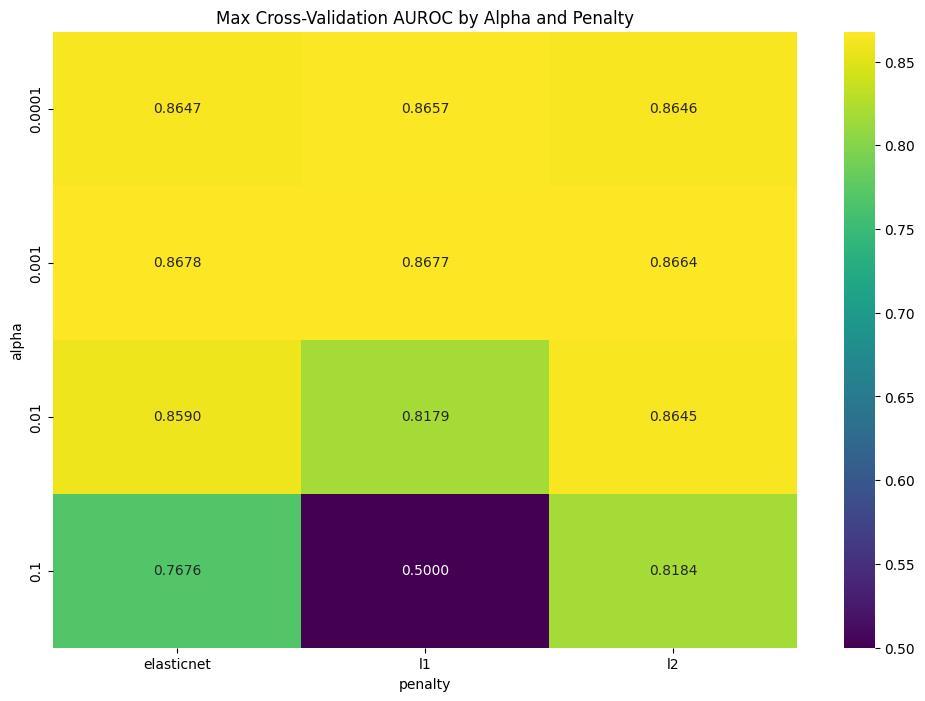

In [7]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
from tqdm import tqdm
import pandas as pd

print("Hyperparameter Tuning with 10-Fold Cross-Validation")
best_mean_auroc = 0
best_params = {}
best_model = None

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Parameter grid
alpha_values = [0.0001, 0.001, 0.01, 0.1]  # Regularization strength
penalty_values = ['l2', 'l1', 'elasticnet']  # Regularization type
learning_rate_values = ['optimal', 'invscaling', 'constant', 'adaptive']  # Learning rate schedule
eta0_values = [0.01, 0.1, 1]  # Initial learning rate, must be > 0

# Calculate total number of parameter combinations
total_combinations = len(alpha_values) * len(penalty_values) * len(learning_rate_values) * len(eta0_values)
print(f"Searching for optimal hyperparameters across {total_combinations} combinations...")

# Store results for later analysis
results_list = []

# Use tqdm for progress tracking
pbar = tqdm(total=total_combinations)

for alpha in alpha_values:
    for penalty in penalty_values:
        for learning_rate in learning_rate_values:
            for eta0 in eta0_values:
                # Skip combinations where eta0 is not needed
                if learning_rate == 'optimal' and eta0 != eta0_values[0]:
                    pbar.update(1)
                    continue
                
                # Ensure eta0 is used only when necessary
                params = {
                    'loss': 'log_loss', 'alpha': alpha, 'penalty': penalty,
                    'max_iter': 1000, 'tol': 1e-3, 'learning_rate': learning_rate,
                    'random_state': 42
                }
                
                # eta0 is required for 'constant', 'invscaling', and 'adaptive' learning rates
                if learning_rate in ['constant', 'invscaling', 'adaptive']:
                    params['eta0'] = eta0
                
                try:
                    # List to store AUROC scores for each fold
                    fold_aurocs = []
                    
                    # Perform cross-validation
                    for train_idx, val_idx in cv.split(X_train, y_train):
                        # Split data for this fold
                        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
                        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
                        
                        # Create and train SGD Logistic Regression model with current parameters
                        current_sgd = SGDClassifier(**params)
                        current_sgd.fit(X_fold_train, y_fold_train)
                        
                        # Evaluate on validation fold using AUROC
                        val_probas = current_sgd.predict_proba(X_fold_val)[:, 1]  # Get positive class probabilities
                        auroc_val = roc_auc_score(y_fold_val, val_probas)
                        fold_aurocs.append(auroc_val)
                    
                    # Calculate mean and standard deviation across folds
                    mean_auroc = np.mean(fold_aurocs)
                    std_auroc = np.std(fold_aurocs)
                    
                    eta0_text = eta0 if learning_rate in ['constant', 'invscaling', 'adaptive'] else 'N/A'
                    print(f"Parameters: alpha={alpha}, penalty={penalty}, learning_rate={learning_rate}, eta0={eta0_text}, CV AUROC={mean_auroc:.4f} ± {std_auroc:.4f}")
                    
                    # Store results
                    results_list.append({
                        'alpha': alpha,
                        'penalty': penalty,
                        'learning_rate': learning_rate,
                        'eta0': eta0_text,
                        'mean_auroc': mean_auroc,
                        'std_auroc': std_auroc
                    })
                    
                    # Track best model based on mean AUROC
                    if mean_auroc > best_mean_auroc:
                        best_mean_auroc = mean_auroc
                        best_params = {
                            'alpha': alpha,
                            'penalty': penalty,
                            'learning_rate': learning_rate,
                            'eta0': eta0_text if eta0_text != 'N/A' else None
                        }
                
                except Exception as e:
                    print(f"Error with parameters: alpha={alpha}, penalty={penalty}, learning_rate={learning_rate}, eta0={eta0 if learning_rate in ['constant', 'invscaling', 'adaptive'] else 'N/A'}")
                    print(f"Error message: {str(e)}")
                
                # Update progress bar
                pbar.update(1)

pbar.close()

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results_list)
print("\nTop 5 parameter combinations:")
print(results_df.sort_values('mean_auroc', ascending=False).head(5))

# Create final model with best parameters
final_params = {
    'loss': 'log_loss', 
    'alpha': best_params['alpha'], 
    'penalty': best_params['penalty'],
    'learning_rate': best_params['learning_rate'],
    'max_iter': 1000, 
    'tol': 1e-3,
    'random_state': 42
}

if best_params['eta0'] is not None:
    final_params['eta0'] = best_params['eta0']

print(f"\nBest Parameters: {best_params}")
print(f"Best Cross-Validation AUROC: {best_mean_auroc:.4f}")

# Train final model with best parameters on the full training set
best_model = SGDClassifier(**final_params)
best_model.fit(X_train, y_train)

# If you want to evaluate the best model on a test set (if available)
if 'X_test' in locals() and 'y_test' in locals():
    test_probas = best_model.predict_proba(X_test)[:, 1]
    test_auroc = roc_auc_score(y_test, test_probas)
    print(f"Test set AUROC for best model: {test_auroc:.4f}")

# Save the best model
import joblib
joblib.dump(best_model, 'best_sgd_model.pkl')
print("Best model saved as 'best_sgd_model.pkl'")

# Use the best model found
clf = best_model

# Optionally, plot heatmap of performances
import matplotlib.pyplot as plt
import seaborn as sns

# Create pivot table of mean AUROC scores grouped by alpha and penalty
plt.figure(figsize=(12, 8))
pivot = results_df.pivot_table(
    index='alpha', 
    columns='penalty',
    values='mean_auroc',
    aggfunc='max'  # Max AUROC across learning_rate and eta0 values
)
sns.heatmap(pivot, annot=True, cmap='viridis', fmt='.4f')
plt.title('Max Cross-Validation AUROC by Alpha and Penalty')
plt.savefig('sgd_performance_heatmap.png')

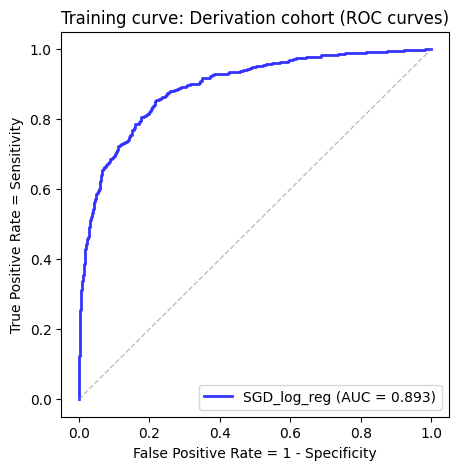

Training AUROC: 0.893 (95% CI: 0.874, 0.910)


In [8]:
# Predict on training data
pred_probas_train = clf.predict_proba(X_train)
risk_groups_train = results(pred_probas_train)

# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_train, pred_probas_train[:,1])
roc_auc = auc(fpr, tpr)
plot_ROC_curve(fpr, tpr, roc_auc, 'Training curve: Derivation cohort (ROC curves)')

# Compute AUROC CI
auroc_ci_lower_train, auroc_ci_upper_train = bootstrap_metric_ci(y_train, pred_probas_train[:,1], "auroc")

print(f"Training AUROC: {roc_auc:.3f} (95% CI: {auroc_ci_lower_train:.3f}, {auroc_ci_upper_train:.3f})")


Val


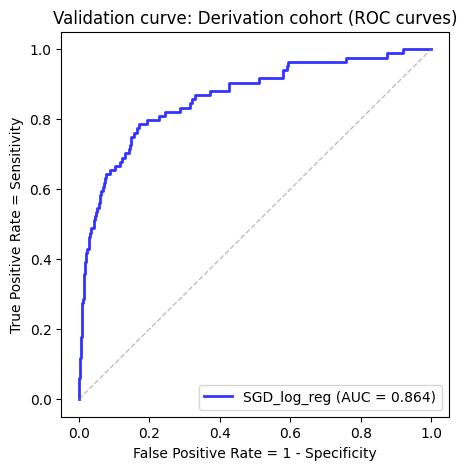

Val AUROC: 0.864 (95% CI: 0.817, 0.904)


In [9]:
# Evaluate on validation set
print("\nVal")
pred_probas_val = clf.predict_proba(X_val)
risk_groups_val = results(pred_probas_val)

# Compute ROC curve and area under the curve for validation set
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, pred_probas_val[:,1])
roc_auc_val = auc(fpr_val, tpr_val)
plot_ROC_curve(fpr_val, tpr_val, roc_auc_val, 'Validation curve: Derivation cohort (ROC curves)')

# Compute AUROC CI
auroc_ci_lower_val, auroc_ci_upper_val = bootstrap_metric_ci(y_val, pred_probas_val[:,1], "auroc")

print(f"Val AUROC: {roc_auc_val:.3f} (95% CI: {auroc_ci_lower_val:.3f}, {auroc_ci_upper_val:.3f})")